In [1]:
import pandas as pd
from utils_analysis import prepare_scores
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("data/debatesum/test.csv")

# "results/bart/r1/bart-base_data_debatesum_checkpoint-1500_debatesum.json",
# "results/bart/r2/bart-base_data_debatesum_checkpoint-1500_debatesum.json",
# "results/bart/r3/bart-base_data_debatesum_checkpoint-1500_debatesum.json",
# "results/t5/r1/flan-t5-base_data_debatesum_checkpoint-1500_debatesum.json",
# "results/t5/r2/flan-t5-base_data_debatesum_checkpoint-1500_debatesum.json",
# "results/t5/r3/flan-t5-base_data_debatesum_checkpoint-1500_debatesum.json",

df_scores, beam_search_results = prepare_scores(
    "results/bart/r3/bart-base_data_debatesum_checkpoint-1500_debatesum.json",
    df["target"],
    "rougeL",
)

/home/mila/f/floresl/beam-search/utils_analysis.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  abs(spearmanr(ground_truth_score, confidence_score_dict[str(k)]).statistic)  # type: ignore


In [3]:
beam_score_log_probs = pd.DataFrame(beam_search_results["beam_score_log_probs"])
worst_rouge_idxs = df_scores.sort_values(by="rougeL").index[:100]
best_rouge_idxs = df_scores.sort_values(by="rougeL").index[::-1][:100]

Text(0, 0.5, 'Joint Sequence Token Probability')

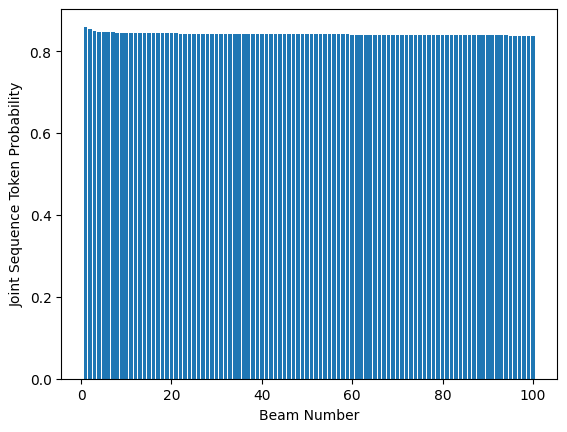

In [4]:
plt.bar(
    x=list(range(1, 101)),
    height=np.exp(beam_score_log_probs.loc[worst_rouge_idxs[0]]),
)
plt.xlabel("Beam Number")
plt.ylabel("Joint Sequence Token Probability")

Text(0, 0.5, 'Joint Sequence Token Probability')

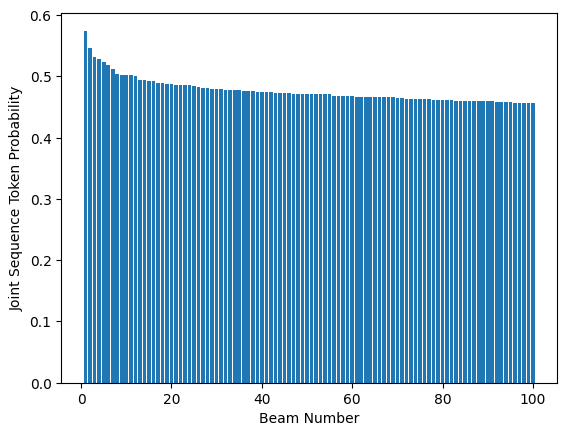

In [5]:
plt.bar(
    x=list(range(1, 101)),
    height=np.exp(beam_score_log_probs.loc[best_rouge_idxs[-1]]),
)
plt.xlabel("Beam Number")
plt.ylabel("Joint Sequence Token Probability")

In [6]:
df_scores.drop(["sentences", "dropout_sentences"], axis=1).corr(method="spearman")[
    "rougeL"
]

length_normalized_log_probs   -0.446520
mean_token_entropy             0.415982
dropout_bleu_variance          0.137664
dropout_meteor_score           0.199192
dropout_entropy               -0.134216
dropout_disagreement          -0.081978
rougeL                         1.000000
beam_score_ratios_89           0.495672
beam_score_log_probs_89       -0.495458
beam_score_top_k_89           -0.489117
beam_score_impt_wt_89          0.488955
Name: rougeL, dtype: float64

In [7]:
from utils_tail_probs import softmax, tail_index
from scipy.stats import spearmanr

In [8]:
tail_indices = []
for i in range(len(beam_score_log_probs)):
    probs = softmax(beam_score_log_probs.iloc[i].to_numpy(), temperature=1)
    tail_indices.append(tail_index(probs))

spearmanr(tail_indices, df_scores["rougeL"])

SignificanceResult(statistic=0.5181897642161295, pvalue=8.383792610274369e-70)

In [9]:
import json

baseline_probs = json.load(
    open(
        "/home/mila/f/floresl/beam-search/results/bart_baseline/facebook_bart-base_debatesum.json",
        "r",
    )
)

In [11]:
baseline_log_probs = baseline_probs["beam_score_log_probs"]

In [27]:
k = 1

In [28]:
spearmanr(
    [a - b for (a, b) in zip(beam_score_log_probs[str(k)], baseline_log_probs[str(k)])],
    df_scores["rougeL"],
)

SignificanceResult(statistic=-0.4535501988697596, pvalue=6.82578834185028e-52)